In [27]:
%matplotlib ipympl
# Activate auto reload 
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from pymatgen.core import Structure
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.interpolate import griddata
from matplotlib import colors
from matplotlib import rcParams
from copy import copy
import nglview
from ase.build import bulk
from ase.visualize import view
from ase.geometry import cell_to_cellpar
from ase import Atoms
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pyccapt.calibration.reconstructions import sdm, rdf, fft
from pyccapt.calibration.reconstructions import density_map
from pyccapt.calibration.reconstructions import crystal_helper
from pyccapt.calibration.data_tools import data_tools, data_loadcrop
from pyccapt.calibration.leap_tools import ccapt_tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# Import necessary libraries

structure = Structure.from_file('Al.cif')
structure.make_supercell([1,1,1])
print(structure)
print("Atomic coordinates:")
for i, site in enumerate(structure.sites):
    print(f"  Site {i + 1}: {site.species_string} at {site.coords} (Cartesian)")
view_ngl = nglview.show_pymatgen(structure)

view_ngl.add_unitcell()
# view_ngl.camera = "perspective"
view_ngl.camera = "orthographic"
# Display the structure
# view_ngl.control.spin([0, 1, 0], 0)  # Rotation around z-axis


view_ngl.shape.add_arrow([-4, -4, -4], [0, -4, -4], [1, 0, 0], 0.5, "x-axis")
view_ngl.shape.add_arrow([-4, -4, -4], [-4, 0, -4], [0, 1, 0], 0.5, "y-axis")
view_ngl.shape.add_arrow([-4, -4, -4], [-4, -4, 0], [0, 0, 1], 0.5, "z-axis")
view_ngl.display()


Full Formula (Al4)
Reduced Formula: Al
abc   :   4.038930   4.038930   4.038930
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
Sites (4)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Al    0    0    0
  1  Al    0.5  0.5  0
  2  Al    0.5  0    0.5
  3  Al    0    0.5  0.5
Atomic coordinates:
  Site 1: Al at [0. 0. 0.] (Cartesian)
  Site 2: Al at [2.01946485e+00 2.01946484e+00 2.47313116e-16] (Cartesian)
  Site 3: Al at [2.01946484 0.         2.01946484] (Cartesian)
  Site 4: Al at [3.24754716e-16 2.01946484e+00 2.01946484e+00] (Cartesian)


NGLWidget()

In [3]:
from pymatgen.core import Structure
from pymatgen.analysis.structure_analyzer import SpacegroupAnalyzer

# Load the structure from CIF file
structure = Structure.from_file("Al.cif")

# Analyze symmetry
sym_analyzer = SpacegroupAnalyzer(structure)
print(sym_analyzer)
    

# Specify Miller index of interest
miller_index = (1, 0, 0)  # Replace with the Miller indices you want

# Calculate interplanar spacing
d_hkl = structure.lattice.d_hkl(miller_index)
print(f"Distance between planes with Miller index {miller_index}: {d_hkl} Å")


Distance between planes with Miller index (1, 0, 0): 4.038929690000001 Å


In [4]:
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

# Load the structure from a CIF file
structure = Structure.from_file('Al.cif')

# 1. Lattice Properties
print("Lattice Properties:")
print(f"  - Lattice Vectors (Å):\n    a = {structure.lattice.a}\n    b = {structure.lattice.b}\n    c = {structure.lattice.c}")
print(f"  - Lattice Parameters (a, b, c): {structure.lattice.abc}")
print(f"  - Lattice Angles (α, β, γ): {structure.lattice.angles}")
print(f"  - Volume: {structure.lattice.volume} Å³")
print(f"  - Reciprocal Lattice Vectors:\n    {structure.lattice.reciprocal_lattice}")

# 2. Atomic Properties
print("\nAtomic Properties:")
print(f"  - Number of Sites: {len(structure)}")
print(f"  - Species at each site:")
for i, site in enumerate(structure.sites):
    print(f"    Site {i + 1}: {site.specie.symbol} at {site.coords} (Cartesian)")

# 3. Symmetry Features
print("\nSymmetry Features:")
space_group_info = structure.get_space_group_info()
print(f"  - Space Group: {space_group_info[0]} (number {space_group_info[1]})")

# Get the point group using SpacegroupAnalyzer
analyzer = SpacegroupAnalyzer(structure)
point_group = analyzer.get_point_group_symbol()
print(f"  - Point Group: {point_group}")

# print("  - Symmetry Operations:")
# for op in analyzer.get_symmetry_operations():
#     print(f"    {op}")


Lattice Properties:
  - Lattice Vectors (Å):
    a = 4.03892969
    b = 4.03892969
    c = 4.03892969
  - Lattice Parameters (a, b, c): (4.03892969, 4.03892969, 4.03892969)
  - Lattice Angles (α, β, γ): (90.0, 90.0, 90.0)
  - Volume: 65.88687036791546 Å³
  - Reciprocal Lattice Vectors:
    1.555656025094011 -2.5016856890596055e-16 0.0
0.0 1.555656025094011 0.0
-9.525645858528378e-17 -9.525645858528375e-17 1.555656025094011

Atomic Properties:
  - Number of Sites: 4
  - Species at each site:
    Site 1: Al at [0. 0. 0.] (Cartesian)
    Site 2: Al at [2.01946485e+00 2.01946484e+00 2.47313116e-16] (Cartesian)
    Site 3: Al at [2.01946484 0.         2.01946484] (Cartesian)
    Site 4: Al at [3.24754716e-16 2.01946484e+00 2.01946484e+00] (Cartesian)

Symmetry Features:
  - Space Group: Fm-3m (number 225)
  - Point Group: m-3m


In [5]:
# structure = Structure.from_file('Ti.cif')
# structure.make_supercell(10)

structure = Structure.from_file('Al.cif')
structure.make_supercell(10)
# Check the number of atoms
num_atoms = structure.num_sites
print(f"Number of atoms in the structure: {num_atoms}")
# Get lattice parameters
a, b, c = structure.lattice.abc  # lengths of lattice vectors in Å
alpha, beta, gamma = structure.lattice.angles  # angles between lattice vectors in degrees

print(f"Lattice parameters:")
print(f"a = {a:.3f} Å, b = {b:.3f} Å, c = {c:.3f} Å")
print(f"Angles: α = {alpha:.2f}°, β = {beta:.2f}°, γ = {gamma:.2f}°")

# Get the density in g/cm³
density = structure.density
print(f"Density: {density:.3f} g/cm³")

# Calculate atom density (atoms per cubic angstrom)
num_atoms = structure.num_sites
volume = structure.volume  # Volume in cubic angstroms (Å³)
atom_density = num_atoms / volume
print(f"Atom density: {atom_density:.3f} atoms/Å³")

# Create an NGLView object
view_ngl = nglview.show_pymatgen(structure)

# Update atomic positions with noisy coordinates
# view.update_coordinates(coords)

view_ngl.add_unitcell()
view_ngl.camera = "perspective"
# view_ngl.camera = "orthographic"
# Display the structure
# view_ngl.control.spin([0, 0, 1], 0)  # Rotation around z-axis
view_ngl.display()

Number of atoms in the structure: 4000
Lattice parameters:
a = 40.389 Å, b = 40.389 Å, c = 40.389 Å
Angles: α = 90.00°, β = 90.00°, γ = 90.00°
Density: 2.720 g/cm³
Atom density: 0.061 atoms/Å³


NGLWidget()

In [6]:
structure = Structure.from_file('Al.cif')
structure = structure.make_supercell(10)

# Get the lattice parameters of the supercell in Ångströms
a, b, c = structure.lattice.abc  # lengths of lattice vectors in Å

# Convert to nanometers
a_nm = a * 0.1
b_nm = b * 0.1
c_nm = c * 0.1

print(f"Dimensions of the 4x4x4 supercell in nanometers:")
print(f"a = {a_nm:.3f} nm, b = {b_nm:.3f} nm, c = {c_nm:.3f} nm")

Dimensions of the 4x4x4 supercell in nanometers:
a = 4.039 nm, b = 4.039 nm, c = 4.039 nm


In [7]:
structure = Structure.from_file('Al.cif')
# Create a 4x4x4 supercell
supercell = structure.copy()
supercell.make_supercell([4, 4, 4])

# Calculate the atom density
num_atoms_supercell = supercell.num_sites      # Total number of atoms in the supercell
volume_supercell = supercell.volume            # Volume of the supercell in cubic angstroms
atom_density_supercell = num_atoms_supercell / volume_supercell  # atoms per cubic angstrom

print(f"Number of atoms in 4x4x4 supercell: {num_atoms_supercell}")
print(f"Volume of 4x4x4 supercell: {volume_supercell:.3f} Å³")
print(f"Atom density: {atom_density_supercell:.5f} atoms/Å³")
print('---------------------------------------------')

Number of atoms in 4x4x4 supercell: 256
Volume of 4x4x4 supercell: 4216.760 Å³
Atom density: 0.06071 atoms/Å³
---------------------------------------------


Dimensions of the 4x4x4 supercell in nanometers:
a = 4.039 nm, b = 4.039 nm, c = 4.039 nm


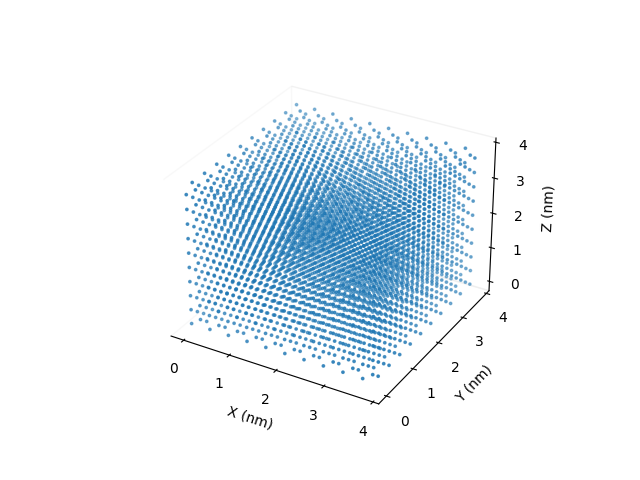

In [8]:
structure = Structure.from_file('Al.cif')
structure = structure.make_supercell(10)

# Get the lattice parameters of the supercell in Ångströms
a, b, c = structure.lattice.abc  # lengths of lattice vectors in Å

# Convert to nanometers
a_nm = a * 0.1
b_nm = b * 0.1
c_nm = c * 0.1

print(f"Dimensions of the 4x4x4 supercell in nanometers:")
print(f"a = {a_nm:.3f} nm, b = {b_nm:.3f} nm, c = {c_nm:.3f} nm")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

coords = structure.cart_coords
# Plot atomic positions
ax.scatter(coords[:,0]/10, coords[:,1]/10, coords[:,2]/10, s=3)

# Set axis labels
ax.set_xlabel('X (nm)')
ax.set_ylabel('Y (nm)')
ax.set_zlabel('Z (nm)')

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False)

# Show the plot
plt.show()

In [9]:
structure = Structure.from_file('Al.cif')
structure.make_supercell([5,5,15])
# Check the number of atoms
num_atoms = structure.num_sites
print(f"Number of atoms in the structure: {num_atoms}")
# Create an NGLView object
view_ngl = nglview.show_pymatgen(structure)

# Update atomic positions with noisy coordinates
# view.update_coordinates(coords)

view_ngl.add_unitcell()
view_ngl.camera = "perspective"
# Display the structure
# view_ngl.control.spin([0, 0, 1], 0)  # Rotation around z-axis
view_ngl.display()

Number of atoms in the structure: 1500


NGLWidget()

In [10]:
structure = Structure.from_file('Al.cif')
structure.make_supercell([5,5,15])
# Check the number of atoms
num_atoms = structure.num_sites
print(f"Number of atoms in the structure: {num_atoms}")

# Define the noise level in Angstroms (e.g., 0.05 means atoms are shifted by up to 0.05 Å in each direction)
noise_level = 0.5

# Apply random displacements to each site in the structure
for site in structure.sites:
    displacement = np.random.uniform(-noise_level, noise_level, 3)  # Random shift in x, y, z
    site.coords += displacement

view_ngl = nglview.show_pymatgen(structure)
view_ngl.camera = "perspective"
view_ngl.display()


Number of atoms in the structure: 1500


NGLWidget()

In [11]:
structure = Structure.from_file('Al.cif')
# supper_cell = [120,120,600]
supper_cell = [40,40,120]
structure = structure.make_supercell(supper_cell)

num_atoms = structure.num_sites
print(f"Number of atoms in the structure: {num_atoms}")

# Get the lattice parameters of the supercell in Ångströms
a, b, c = structure.lattice.abc  # lengths of lattice vectors in Å

# Convert to nanometers
a_nm = a * 0.1
b_nm = b * 0.1
c_nm = c * 0.1

print(f"Dimensions of the {supper_cell[0]}x{supper_cell[1]}x{supper_cell[2]} supercell in nanometers:")
print(f"a = {a_nm:.3f} nm, b = {b_nm:.3f} nm, c = {c_nm:.3f} nm")

# Create a new NGLView object to visualize the filtered structure
view_ngl_structure= nglview.show_pymatgen(structure)

# Visualize the filtered structure with the virtual cone and hemisphere
# view_ngl_filtered.add_unitcell()
view_ngl_structure.camera = "perspective"
view_ngl_structure.add_unitcell()
view_ngl_structure.display()

Number of atoms in the structure: 768000
Dimensions of the 40x40x120 supercell in nanometers:
a = 16.156 nm, b = 16.156 nm, c = 48.467 nm


NGLWidget()

In [12]:
filtered_structure, filtered_coords = crystal_helper.filter_atoms_in_cone_and_hemisphere(structure, min(structure.lattice.a, structure.lattice.b), 2*structure.lattice.c, structure.lattice.c*0.7)
num_atoms = filtered_structure.num_sites
print(f"Number of atoms in the structure: {num_atoms}")
# Get the lattice parameters of the supercell in Ångströms
a, b, c = filtered_structure.lattice.abc  # lengths of lattice vectors in Å

# Convert to nanometers
a_nm = a * 0.1
b_nm = b * 0.1
c_nm = c * 0.1

print(f"Dimensions of the {supper_cell[0]}x{supper_cell[1]}x{supper_cell[2]} supercell in nanometers:")
print(f"a = {a_nm:.3f} nm, b = {b_nm:.3f} nm, c = {c_nm:.3f} nm")

# Print minimum and maximum values along each coordinate axis (x, y, z)
min_coords = np.min(filtered_coords, axis=0)  # Minimum of each column (x, y, z)
max_coords = np.max(filtered_coords, axis=0)  # Maximum of each column (x, y, z)

print("Minimum coordinates (x, y, z):", min_coords)
print("Maximum coordinates (x, y, z):", max_coords)

# Create a new NGLView object to visualize the filtered structure
view_ngl_filtered = nglview.show_pymatgen(filtered_structure)

# Visualize the filtered structure with the virtual cone and hemisphere
view_ngl_filtered.add_unitcell()
view_ngl_filtered.camera = "perspective"
view_ngl_filtered.display()

Number of atoms in the structure: 335110
Dimensions of the 40x40x120 supercell in nanometers:
a = 16.156 nm, b = 16.156 nm, c = 48.467 nm
Minimum coordinates (x, y, z): [1.10416603e-14 0.00000000e+00 2.96775739e-15]
Maximum coordinates (x, y, z): [159.53772276 159.53772276 442.26280105]


NGLWidget()

In [31]:
hemispherical = crystal_helper.project_to_surface(filtered_structure)

# Create a new NGLView object to visualize the filtered structure
view_ngl_r = nglview.show_pymatgen(hemispherical)

# Visualize the filtered structure with the virtual cone and hemisphere
# view_ngl_r.add_unitcell()
# view_ngl_r.camera = "perspective"

view_ngl_r.camera = "orthographic"
view_ngl_r.center()
view_ngl_r.display()

NGLWidget()

In [268]:
def project_to_surface(structure):
    """
    Projects all atomic positions onto the surface.

    Parameters:
    structure (Structure): A pymatgen Structure object with atomic positions.

    Returns:
    Structure: A new Structure object with all atomic positions projected onto the hemisphere surface.
    """
    # Copy the structure to avoid modifying the original
    projected_structure = structure.copy()

    # Extract atomic coordinates
    coords = projected_structure.cart_coords

    # Find the midpoints of x and y
    min_x, max_x = np.min(coords[:, 0]), np.max(coords[:, 0])
    min_y, max_y = np.min(coords[:, 1]), np.max(coords[:, 1])

    mid_x = (max_x + min_x) / 2
    mid_y = (max_y + min_y) / 2

    # Center the coordinates on x = 0 and y = 0
    coords[:, 0] -= mid_x
    coords[:, 1] -= mid_y

    # Manually compute the norm for each coordinate point
    current_radii = np.sqrt(coords[:, 0]**2 + coords[:, 1]**2 + coords[:, 2]**2)
    # current_radii = np.sqrt(coords[:, 2]**2)
    print(current_radii[:, None].shape)
    print(current_radii[4, None], np.min(current_radii))
    # Normalize coordinates to lie on the unit sphere (radius = 1)
    coords[:, 0] = coords[:, 0] / current_radii
    coords[:, 1] = coords[:, 1] / current_radii
    coords[:, 2] = coords[:, 2] / current_radii

    # Create a new structure with the projected coordinates
    projected_structure = Structure(structure.lattice, structure.species, coords)

    return projected_structure



hemispherical = project_to_surface(filtered_structure)

# Create a new NGLView object to visualize the filtered structure
view_ngl_r = nglview.show_pymatgen(hemispherical)

# Visualize the filtered structure with the virtual cone and hemisphere
# view_ngl_r.add_unitcell()
# view_ngl_r.camera = "perspective"
view_ngl_r.camera = "orthographic"
view_ngl_r.center()
view_ngl_r.display()


(335110, 1)
[79.82635706] 1.4279772862673312


NGLWidget()

(4000, 3)


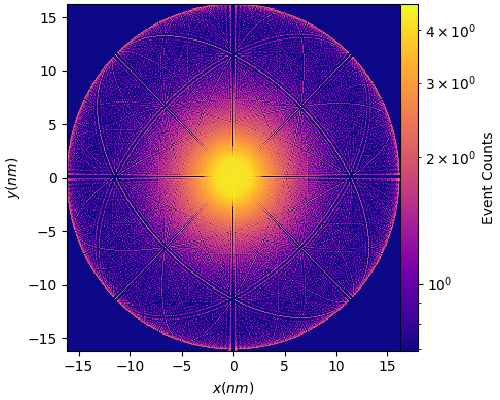

In [32]:
coords_r = hemispherical.cart_coords
# cmap: plasma, viridis, inferno, cividis, coolwarm, twilight, cubehelix, 
density_map.plot_density_map(coords_r[:,0]/10, coords_r[:,1]/10, bins=0.1, cmap='plasma')
print(coords.shape)

In [30]:
rotated_structure = crystal_helper.rotate_structure(filtered_structure, 11, 11)
# Create a new NGLView object to visualize the filtered structure
view_ngl_r = nglview.show_pymatgen(rotated_structure)

# Visualize the filtered structure with the virtual cone and hemisphere
view_ngl_r.add_unitcell()
view_ngl_r.camera = "perspective"
view_ngl_r.shape.add_arrow([-4, -4, -4], [0, -4, -4], [1, 0, 0], 0.5, "x-axis")
view_ngl_r.shape.add_arrow([-4, -4, -4], [-4, 0, -4], [0, 1, 0], 0.5, "y-axis")
view_ngl_r.shape.add_arrow([-4, -4, -4], [-4, -4, 0], [0, 0, 1], 0.5, "z-axis")
view_ngl_r.display()

NGLWidget()

In [24]:
hemispherical_r = crystal_helper.project_to_surface(rotated_structure)
# Create a new NGLView object to visualize the filtered structure
view_ngl_r = nglview.show_pymatgen(hemispherical_r)

# Visualize the filtered structure with the virtual cone and hemisphere
view_ngl_r.camera = "perspective"
view_ngl_r.display()

NGLWidget()

(4000, 3)


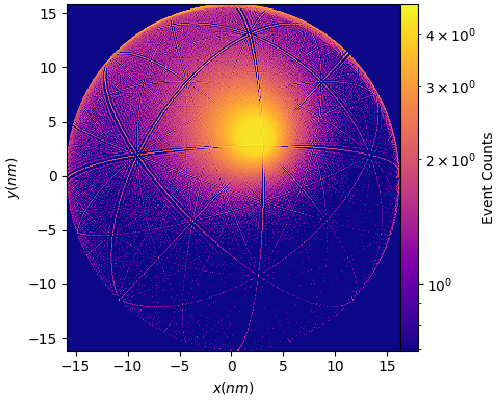

In [25]:
coords_r = hemispherical_r.cart_coords
# cmap: plasma, viridis, inferno, cividis, coolwarm, twilight, cubehelix, 
density_map.plot_density_map(coords_r[:,0]/10, coords_r[:,1]/10, bins=0.1, cmap='plasma')
print(coords.shape)

In [16]:
# structure = Structure.from_file('Al.cif')
# supper_cell = [120,120,600]
# structure = structure.make_supercell(supper_cell)

# num_atoms = structure.num_sites
# print(f"Number of atoms in the structure: {num_atoms}")

# # Get the lattice parameters of the supercell in Ångströms
# a, b, c = structure.lattice.abc  # lengths of lattice vectors in Å

# # Convert to nanometers
# a_nm = a * 0.1
# b_nm = b * 0.1
# c_nm = c * 0.1

# print(f"Dimensions of the {supper_cell[0]}x{supper_cell[1]}x{supper_cell[2]} supercell in nanometers:")
# print(f"a = {a_nm:.3f} nm, b = {b_nm:.3f} nm, c = {c_nm:.3f} nm")



# filtered_structure, filtered_coords = crystal_helper.filter_atoms_in_cone_and_hemisphere(structure, min(structure.lattice.a, structure.lattice.b), 2*structure.lattice.c, structure.lattice.c*0.8)
# num_atoms = filtered_structure.num_sites
# print(f"Number of atoms in the structure: {num_atoms}")
# # Get the lattice parameters of the supercell in Ångströms
# a, b, c = filtered_structure.lattice.abc  # lengths of lattice vectors in Å

# # Convert to nanometers
# a_nm = a * 0.1
# b_nm = b * 0.1
# c_nm = c * 0.1

# print(f"Dimensions of the {supper_cell[0]}x{supper_cell[1]}x{supper_cell[2]} supercell in nanometers:")
# print(f"a = {a_nm:.3f} nm, b = {b_nm:.3f} nm, c = {c_nm:.3f} nm")



# # # Create a new NGLView object to visualize the filtered structure
# # view_ngl_filtered = nglview.show_pymatgen(filtered_structure)

# # # Visualize the filtered structure with the virtual cone and hemisphere
# # view_ngl_filtered.add_unitcell()
# # view_ngl_filtered.camera = "perspective"
# # view_ngl_filtered.display()

Number of atoms in the structure: 34560000
Dimensions of the 120x120x600 supercell in nanometers:
a = 48.467 nm, b = 48.467 nm, c = 242.336 nm
Number of atoms in the structure: 15131122
Dimensions of the 120x120x600 supercell in nanometers:
a = 48.467 nm, b = 48.467 nm, c = 242.336 nm


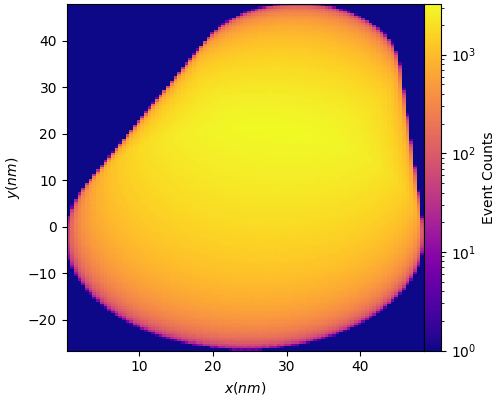

(15131122, 3)


In [22]:
# save
# Save the supercell to disk
# filename = "Al_supercell.cif"  # Save as CIF file (you can use "POSCAR" for VASP format)
# filtered_structure.to(filename)

rotated_structure = crystal_helper.rotate_structure(filtered_structure, 10, 2)

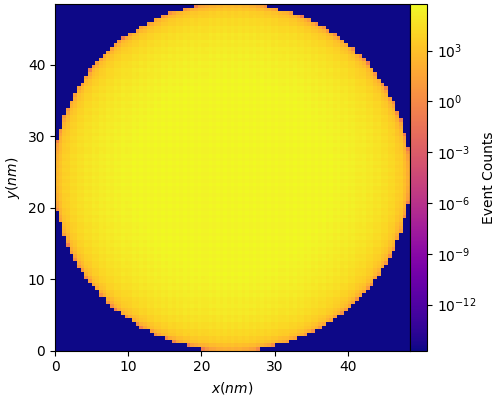

(15131122, 3)


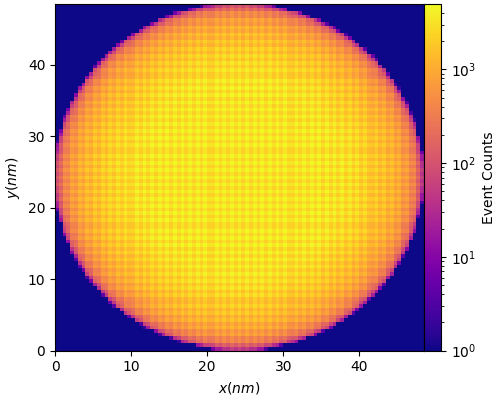

(15131122, 3)


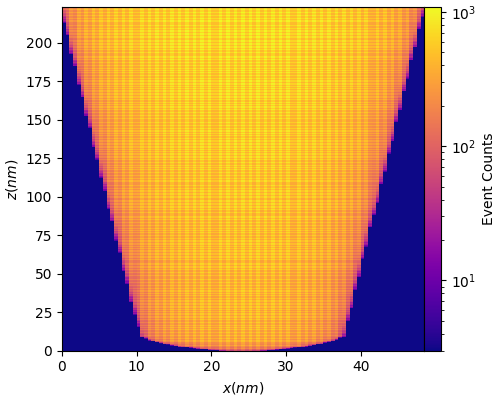

(15131122, 3)


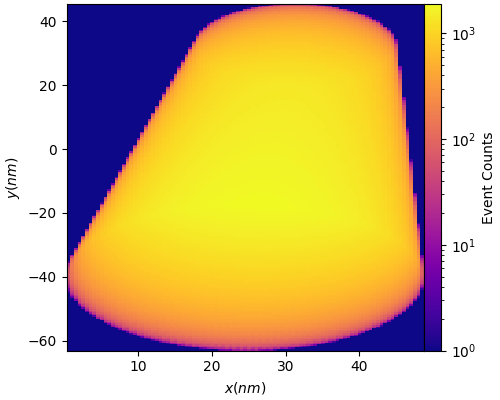

(15131122, 3)


In [21]:
# cmap: plasma, viridis, inferno, cividis, coolwarm, twilight, cubehelix, 
coords = filtered_structure.cart_coords
density_map.plot_density_map(coords[:,0]/10, coords[:,1]/10, z=coords[:,2]/10, bins=0.5, cmap='plasma')
print(coords.shape)

density_map.plot_density_map(coords[:,0]/10, coords[:,1]/10, bins=0.5, cmap='plasma', axis=['x', 'y'])
print(coords.shape)

density_map.plot_density_map(coords[:,0]/10, coords[:,2]/10, bins=0.5, cmap='plasma', axis=['x', 'z'])
print(coords.shape)

coords_r = rotated_structure.cart_coords
density_map.plot_density_map(coords_r[:,0]/10, coords_r[:,1]/10, bins=0.5, cmap='plasma')
print(coords.shape)

In [ ]:
def stereographic_projection(atoms, radius):
    # atoms: a numpy array of atomic positions with shape (n, 3), where n is the number of atoms.
    # radius: the radius of the sphere from which we're projecting.
    
    # Extract x, y, and z coordinates
    x = atoms[:, 0]
    y = atoms[:, 1]
    z = atoms[:, 2]
    
    # Avoid division by zero (for points at the projection pole, e.g., z = radius)
    # To prevent singularities, we should ensure points close to the pole are handled (e.g., removed or set to a limit)
    eps = 1e-9  # Small value to avoid division by zero
    denominator = radius - z + eps  # Adjusted denominator to avoid division by zero
    
    # Compute stereographic projection
    X = (radius * x) / denominator
    Y = (radius * y) / denominator
    
    # Combine X and Y into a 2D array
    projected_atoms = np.column_stack((X, Y))
    
    return projected_atoms


def hemispherical_projection(atoms, radius=False):
    # Normalize the position of each atom to lie on the surface of a sphere with the specified radius
    current_radii = np.linalg.norm(atoms, axis=1)
    if radius is not False:
        scaled_atoms = (atoms / current_radii[:, None]) * radius  # Scale to custom radius
    else:
        scaled_atoms = (atoms / current_radii[:, None])
    return scaled_atoms

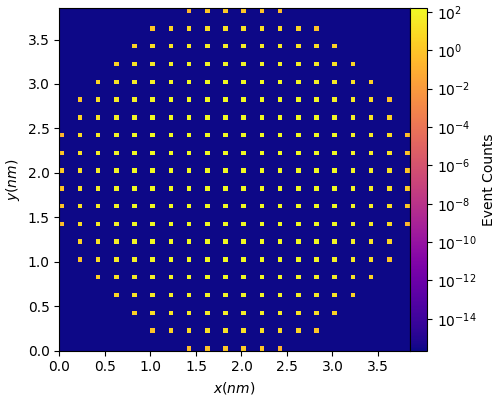

(5288, 3)


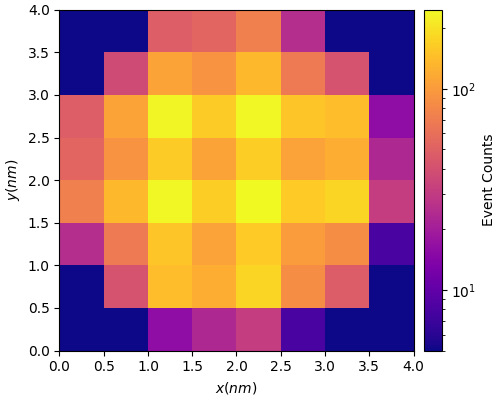

(5288, 3)


e:\pyccapt\pyccapt\calibration\reconstructions\density_map.py:98: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1, ax1 = plt.subplots(figsize=figure_size, constrained_layout=True)


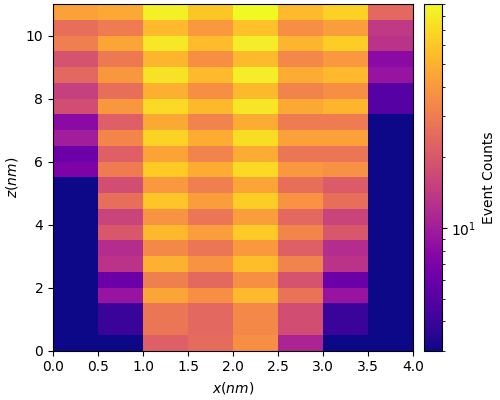

(5288, 3)


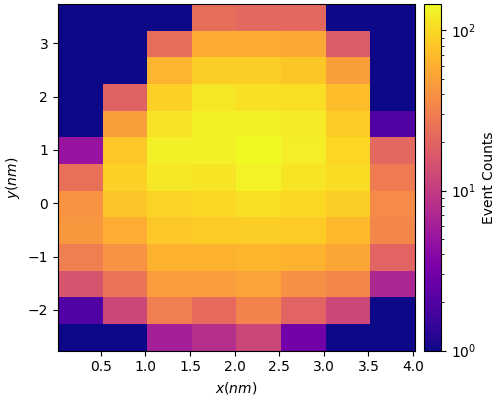

(5288, 3)


In [231]:
data = ccapt_tools.epos_to_ccapt('T:/Monajem/APT_data/Ortner/R56_06768-v01.epos')
data

,x (nm),y (nm),z (nm),mc (Da),mc_uc (Da),high_voltage (V),pulse,t (ns),t_c (ns),x_det (cm),y_det (cm),pulse_pi,ion_pp,start_counter
0,-6.144971,11.178374,1.195138,26.978182,0.0,6306.0,1261.199951,1494.671387,0.0,-0.438439,0.742662,0,1,0
1,-3.438308,4.376252,0.225914,26.978922,0.0,6306.0,1261.199951,1501.300659,0.0,-0.294075,0.279496,77,1,0
2,-3.416219,4.216140,0.214784,27.162317,0.0,6306.0,1261.199951,1506.515747,0.0,-0.291402,0.268849,3,1,0
3,15.602643,-8.348641,2.319220,26.978527,0.0,6306.0,1261.199951,1523.911987,0.0,1.117486,-0.604245,101,1,0
4,11.830281,-6.078051,1.300404,26.980337,0.0,6306.0,1261.199951,1521.128662,0.0,0.807370,-0.439209,21,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13335550,-4.548662,-26.879885,256.886780,26.967958,0.0,7698.0,1539.599976,1347.607788,0.0,-0.165751,-1.522590,10,1,0
13335551,-20.601198,11.899602,255.776855,26.988237,0.0,7698.0,1539.599976,1334.648560,0.0,-1.098772,0.662806,57,1,0
13335552,-20.861986,11.714497,255.816956,27.001881,0.0,7698.0,1539.599976,1334.738281,0.0,-1.109465,0.652158,106,1,0
13335553,13.138130,8.050748,253.758392,26.995007,0.0,7698.0,1539.599976,1375.509033,0.0,0.727168,0.439209,169,1,0


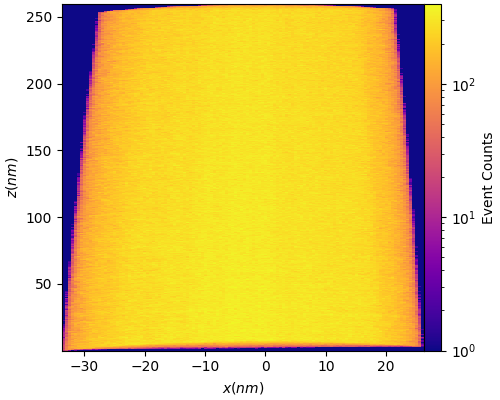

(1125841, 3)


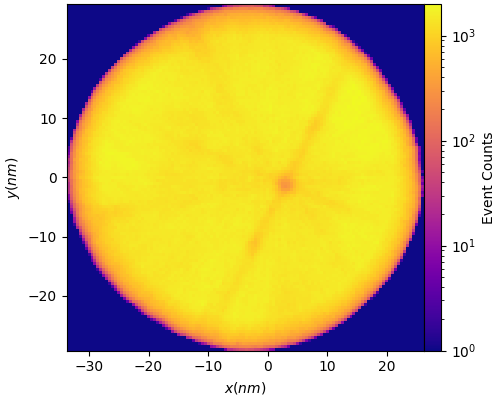

(1125841, 3)


In [62]:
density_map.plot_density_map(data['x (nm)'].to_numpy(), data['z (nm)'].to_numpy(), bins=0.5, cmap='plasma', axis=['x', 'z'])
print(coords.shape)

density_map.plot_density_map(data['x (nm)'].to_numpy(), data['y (nm)'].to_numpy(), bins=0.5, cmap='plasma')
print(coords.shape)